# IPython notebook example of AIBS Cell Types ephys interaction

The Allen Institute for Brain Science just released a new dataset on intracellular patch clamp electrophysiology recordings and morphology from mouse visual cortex neurons: [http://celltypes.brain-map.org](http://celltypes.brain-map.org). 

Here, I'm showing how to access and plot an example dataset in [neurodata-without-borders format](https://crcns.org/NWB). 

Let's download and analyze an [example dataset](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/354190013) of a Scnn1a-Tg2-Cre Primary visual area, layer 5 neuron.

In [1]:
dataset_id = 354190013  # internal ID that AIBS uses for this cell

# Querying the cell types data and metadata using the AIBS SDK tool

AIBS provides a [nice tool via a SDK](http://alleninstitute.github.io/AllenSDK/cell_types.html) for querying and working with the raw ephys dataset. Install it from [here using python's pip](http://alleninstitute.github.io/AllenSDK/install.html)

In [2]:
# we can use the Allen SDK API to easily query the metadata for each of the recorded single cells
from allensdk.api.queries.cell_types_api import CellTypesApi

ct = CellTypesApi()

# use the SDK API to get a list of single cells and corresponding metadata
cell_metadata_list = ct.list_cells(require_reconstruction=False)

# convert that list of cells' metadata to a python dictionary for easy access
cell_meta_dict = {}
for i in range(len(cell_metadata_list)):
    cell_meta_dict[cell_metadata_list[i]['id']] = cell_metadata_list[i]

# print some summary metadata for the cell
print('Some basic metadata from this cell from the API')
print('Cell name: ' , cell_meta_dict[dataset_id]['name'])
print('Cell ID: ' , cell_meta_dict[dataset_id]['id'])
print('Brain region: ' , cell_meta_dict[dataset_id]['structure']['name'])

# uncomment this line to see all the metadata associated with each cell returned from the API
#print cell_meta_dict[dataset_id]


Some basic metadata from this cell from the API
Cell name:  Scnn1a-Tg2-Cre;Ai14(IVSCC)-176962.05.01.01
Cell ID:  354190013
Brain region:  Primary visual area, layer 5


# Downloading the raw ephys data and morphology file for the cell

We can also use the SDK to easily download the electrophysiology and morphology raw data files associated with this cell. [File description](http://alleninstitute.github.io/AllenSDK/cell_types.html).

Downloading the ephys file takes a while since they're ~100 megabytes large...

In [3]:
# download and save the electrophysiology data for one cell

raw_ephys_file_name = '%d_raw_data.nwb' % dataset_id
ct.save_ephys_data(dataset_id, raw_ephys_file_name)

# download and save the reconstruction for the same cell

morphology_file_name = '%d_morphology.swc' % dataset_id
ct.save_reconstruction(dataset_id, morphology_file_name)

# Loading and working with the raw ephys dataset

AIBS provides a [nice tool via a SDK](http://alleninstitute.github.io/AllenSDK/install.html) for working with the raw ephys dataset. 

It nicely abstracts away most of the complexity of working with the [neurodata-without-borders hdf5 file format](https://crcns.org/NWB).

Now, let's query the [Allen Cell Types API](http://help.brain-map.org//display/celltypes/API) to get the file identifier corresponding to the raw electrophysiology dataset for this cell's recording. 

This first requires accessing the AIBS general metadata for this cell and parsing it to figure out where the raw ephys data file is stored.

In [4]:
# load in and read in the NWB raw ephys file using the Allen SDK

from allensdk.core.nwb_data_set import NwbDataSet
data_set = NwbDataSet(raw_ephys_file_name)

In [5]:
# for a specific sweep, use the SDK functions to get the stimulus, response, samp_rate, etc

# import some stuff
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

sweep_number = 60
sweep_data = data_set.get_sweep(sweep_number)

# start/stop indices that exclude the experimental test pulse (if applicable)
index_range = sweep_data['index_range']

# stimulus is a numpy array in amps
stimulus = sweep_data['stimulus'][index_range[0]:index_range[-1]]

# response is a numpy array in volts
response = sweep_data['response'][index_range[0]:index_range[-1]]*1000

# sampling rate is in Hz
sampling_rate = sweep_data['sampling_rate']

# define some time points in seconds (i.e., convert to absolute time)
time_pts = np.arange(0,len(stimulus)/sampling_rate,1./sampling_rate)

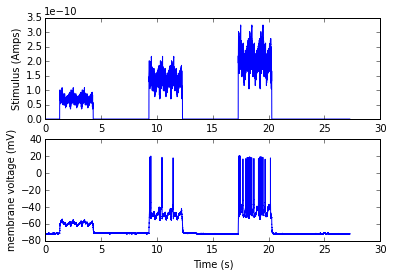

In [6]:
# plot the stimulus and the voltage response for the random trial
plt.subplot(2,1,1)
plt.plot(time_pts,stimulus)
plt.ylabel('Stimulus (Amps)')
plt.subplot(2,1,2)
plt.plot(time_pts,response)
plt.ylabel('membrane voltage (mV)')
plt.xlabel('Time (s)')

# Calculating ephys features from raw data file

It's pretty amazing that AIBS makes so much raw ephys data is made available. Let's calculate a very simple ephys feature, the first spike peak voltage found at rheobase current injection.

In [7]:
# the rheobase trial index for the Long Square Stimulus (figured out by looking at the .nwb file)
rheobase_sweep_index = 46

# get the data for this trial
sweep_data = data_set.get_sweep(rheobase_sweep_index) 
stimulus = sweep_data['stimulus'][index_range[0]:index_range[-1]]
response = sweep_data['response'][index_range[0]:index_range[-1]]*1000
time_pts = np.arange(0,len(stimulus)/sampling_rate,1./sampling_rate)

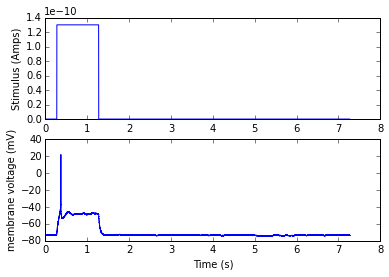

In [8]:
# plot the stimulus and the voltage response for the rheobase trial
plt.subplot(2,1,1)
plt.plot(time_pts,stimulus)
plt.ylabel('Stimulus (Amps)')
plt.subplot(2,1,2)
plt.plot(time_pts,response)
plt.ylabel('membrane voltage (mV)')
plt.xlabel('Time (s)')

# Calculating the spike peak voltage from raw ephys data file 

Let's calculate the spike peak from the raw ephys data file, and then compare this to the stored, processed value encoded within the AIBS database by calling the AIBS API.

The descriptions for how AIBS internally computes features from the ephys data is provided in the [documentation](http://help.brain-map.org/download/attachments/8323525/EphysOverview.pdf?version=1&modificationDate=1431448006652)

In [11]:
# for this trial, calculate the voltage corresponding to the spike peak
rheo_ap_peak_v = np.max(response) # really simple way to get the voltage of the spike peak
rheo_ap_peak_index = np.argmax(response)
rheo_ap_peak_t = time_pts[rheo_ap_peak_index]
print("spike peak at rheobase computed from raw ephys data file:")
print(rheo_ap_peak_v, 'mV')

spike peak at rheobase computed from raw ephys data file:
22.0312504924 mV


# Pulling the spike peak voltage from the pre-calcuated value from the AIBS database

In [16]:
# libraries needed for querying a web url and working with returned json file
try:
    import urllib2
except ImportError:
    import urllib.request as urllib2
import simplejson

# let's now get the summarized data from the Allen API for the voltage for the spike peak
summary_ephys_base_url = "http://api.brain-map.org/api/v2/data/query.json?criteria=model::EphysFeature,rma::criteria,[specimen_id$eq%d]"
summary_ephys_url = summary_ephys_base_url % dataset_id # query url

returned_url_string = urllib2.urlopen(summary_ephys_url).read() # excecutes a web query and gets returned json
aibs_api_json = simplejson.loads(returned_url_string) # makes json object for computed ephys features for this cell

# action potential peak voltage and time
rheo_ap_peak_v_api = aibs_api_json["msg"][0]["peak_v_long_square"]
rheo_ap_peak_t_api = aibs_api_json["msg"][0]["peak_t_long_square"]

print("spike peak at rheobase downloaded from AIBS API:")
print(rheo_ap_peak_v_api, 'mV')

spike peak at rheobase downloaded from AIBS API:
22.0312519073486 mV


# Querying NeuroElectro to compare the AIBS spike peak to prior reports

Given that this is a layer 5 pyramidal cell (based on it's morphology), how does it compare to the summarized ephys from other layer 5 pyramidal cells which have been previously reported?

Let's compare this cell to data from [NeuroElectro layer 5/6 pyramidal cells](http://www.neuroelectro.org/neuron/111/). But clearly, the correspondence between the two cell types isn't perfect...

In [18]:
# layer 5/6 pyramidal cell neuroelectro id
neuroelectro_neuron_id = 111

# neuroelectro spike threshold index
ap_thr_ind = 6
# neuroelectro spike threshold index
ap_amp_ind = 4

# query to get summary data for a neuron type from neuroelectro
url_query = "http://neuroelectro.org/api/1/nes/?n=%d" % neuroelectro_neuron_id
returned_url_string = urllib2.urlopen(url_query).read()
neuroelectro_api_json = simplejson.loads(returned_url_string)

ap_amp_mean = neuroelectro_api_json['objects'][ap_amp_ind]['value_mean']
ap_thr_mean = neuroelectro_api_json['objects'][ap_thr_ind]['value_mean']
ap_peak_mean = ap_amp_mean + ap_thr_mean

print('NeuroElectro estimated average spike peak:')
print(ap_peak_mean, 'mV')

NeuroElectro estimated average spike peak:
45.677713293650804 mV


In [19]:
# Comparing specific AIBS single-cell properties to mean properties compiled from NeuroElectro

In [21]:
# look more into specific single-cell properties by getting them from the aggregated ephys param list
rheo_ap_peak_v_api = aibs_api_json["msg"][0]["peak_v_long_square"]
input_resistance = aibs_api_json["msg"][0]["input_resistance_mohm"]
rheo_ap_thr_v_api = aibs_api_json["msg"][0]["threshold_v_long_square"]
rmp_api = aibs_api_json["msg"][0]["vrest"]
tau_api = aibs_api_json["msg"][0]["tau"]
rheo_ap_amp_v_api = rheo_ap_peak_v_api - rheo_ap_thr_v_api

json_data = simplejson.loads(returned_url_string)

ap_amp_mean = neuroelectro_api_json['objects'][ap_amp_ind]['value_mean']
ap_thr_mean = neuroelectro_api_json['objects'][ap_thr_ind]['value_mean']
rmp_mean = neuroelectro_api_json['objects'][2]['value_mean']
ir_mean = neuroelectro_api_json['objects'][1]['value_mean']
tau_mean = neuroelectro_api_json['objects'][3]['value_mean']

single_cell_params = {'resting potential':rmp_api, 'input resistance': input_resistance, 'membrane tau' : tau_api, 'ap amp' : rheo_ap_amp_v_api, 'ap thr' : rheo_ap_thr_v_api}

neuroelectro_params = {'resting potential':rmp_mean, 'input resistance': ir_mean, 'membrane tau' : tau_mean, 'ap amp' : ap_amp_mean, 'ap thr' : ap_thr_mean}

print('AIBS single cell data')
print(single_cell_params)

print('NeuroElectro summary data for layer 5/6 pyramidal cells')
print(neuroelectro_params)

AIBS single cell data
{'ap amp': 56.4375057220459, 'input resistance': 116.090224, 'membrane tau': 26.2489518949108, 'ap thr': -34.4062538146973, 'resting potential': -73.020389011928}
NeuroElectro summary data for layer 5/6 pyramidal cells
{'ap amp': 85.5503174603175, 'input resistance': 95.8547619047619, 'membrane tau': 14.5940277777778, 'ap thr': -39.8726041666667, 'resting potential': -67.1055769230769}
